# Ensemble Model: WGM + Seasonal Bump

### Score: 0.57682

    WGM with decay: 0.3    # Weight for Weighted Geometric Mean
    Seasonality Bump: 0.6    # Weight for Seasonality Bump

This notebook combines two approaches:
1. Weighted Geometric Mean with exponential decay
2. Simple seasonality bump approach

Final predictions are an ensemble of both methods.

In [33]:
import pandas as pd
import numpy as np
from pathlib import Path

## Configuration

In [ ]:
# ============================================================
# CONFIGURATION SECTION
# ============================================================

# Data Paths
DATA_PATH = '/Users/nikola/Python/KaggleCompetition/data'

# Output Configuration
CONFIG_OUTPUT = {
    'output_dir': '/Users/nikola/Python/KaggleCompetition/output/14_ENSEMBLE_EWGM',
    'submission_filename': '14_EWGM_Kaggle_submission.csv',
}

# Method 1: Weighted Geometric Mean Configuration
CONFIG_METHOD1 = {
    'n_lags': 6,          # Number of months to look back
    'alpha': 0.5,         # Exponential decay parameter (0 < alpha < 1)
    't2': 6,              # Months to check for baseline condition (zero-handling)
}

# Method 2: Seasonality Bump Configuration
CONFIG_METHOD2 = {
    'n_lags': 7,          # Number of months to look back
    'alpha': 0.5,         # Exponential decay parameter
    't2': 6,              # Months to check for baseline condition
    'clip_low': 0.85,     # Lower bound for December multiplier
    'clip_high': 1.40,    # Upper bound for December multiplier
}

# Ensemble Configuration
CONFIG_ENSEMBLE = {
    'weight_method1': 0.3,    # Weight for Weighted Geometric Mean
    'weight_method2': 0.6,    # Weight for Seasonality Bump
}

# Display configuration
print("=" * 60)
print("ENSEMBLE MODEL CONFIGURATION")
print("=" * 60)
print("\nMethod 1 - Weighted Geometric Mean:")
for key, value in CONFIG_METHOD1.items():
    print(f"  {key}: {value}")

print("\nMethod 2 - Seasonality Bump:")
for key, value in CONFIG_METHOD2.items():
    print(f"  {key}: {value}")

print("\nEnsemble Weights:")
for key, value in CONFIG_ENSEMBLE.items():
    print(f"  {key}: {value}")

print("\nOutput:")
print(f"  output_dir: {CONFIG_OUTPUT['output_dir']}")
print(f"  submission_filename: {CONFIG_OUTPUT['submission_filename']}")

ENSEMBLE MODEL CONFIGURATION

Method 1 - Weighted Geometric Mean:
  n_lags: 6
  alpha: 0.5
  t2: 6

Method 2 - Seasonality Bump:
  n_lags: 7
  alpha: 0.5
  t2: 6
  clip_low: 0.85
  clip_high: 1.4

Ensemble Weights:
  weight_method1: 0.3
  weight_method2: 0.6

Output:
  output_dir: /Users/nikola/Python/KaggleCompetition/output/ENSEMBLE_EWGM
  submission_filename: EWGM_Kaggle_submission.csv


## 1. Load Data

In [35]:
# Load training data
train_nht = pd.read_csv(f'{DATA_PATH}/train/new_house_transactions.csv')
test = pd.read_csv(f'{DATA_PATH}/test.csv')

# Convert month to datetime
train_nht['month'] = pd.to_datetime(train_nht['month'])

# Parse test IDs
test_id = test.id.str.split('_', expand=True)
test['month_text'] = test_id[0]
test['sector'] = test_id[1]

# Create month mapping
month_codes = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Add time features
train_nht['year'] = train_nht['month'].dt.year
train_nht['month_num'] = train_nht['month'].dt.month
train_nht['time'] = (train_nht['year'] - 2019) * 12 + train_nht['month_num'] - 1
train_nht['sector_id'] = train_nht.sector.str.slice(7, None).astype(int)

# Parse test data
test['year'] = test['month_text'].str.slice(0, 4).astype(int)
test['month_abbr'] = test['month_text'].str.slice(5, None)
test['month_num'] = test['month_abbr'].map(month_codes)
test['time'] = (test['year'] - 2019) * 12 + test['month_num'] - 1
test['sector_id'] = test.sector.str.slice(7, None).astype(int)

print(f"Training data: {train_nht.shape}")
print(f"Test data: {test.shape}")

Training data: (5433, 15)
Test data: (1152, 9)


/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_18512/2551770686.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_nht['month'] = pd.to_datetime(train_nht['month'])


## 2. Prepare Amount Matrix

In [36]:
# Create pivot table: time x sector_id
amount_matrix = train_nht.set_index(['time', 'sector_id']).amount_new_house_transactions.unstack()
amount_matrix = amount_matrix.fillna(0)

# Add sector 95 (missing in training)
amount_matrix[95] = 0
amount_matrix = amount_matrix[np.arange(1, 97)]

print(f"Amount matrix shape: {amount_matrix.shape}")
print(f"Time range: {amount_matrix.index.min()} to {amount_matrix.index.max()}")

Amount matrix shape: (67, 96)
Time range: 0 to 66


## 3. Method 1: Weighted Geometric Mean (Exponential Decay)

In [37]:
def weighted_geometric_mean_prediction(amount_matrix, n_lags=6, alpha=0.5, t2=6):
    """
    Weighted geometric mean with exponential decay
    
    Parameters:
    - n_lags: number of months to use
    - alpha: exponential decay parameter (0.5 works best)
    - t2: months to check for baseline condition
    """
    # Generate exponential weights
    weights = np.array([alpha**(n_lags-1-i) for i in range(n_lags)])
    weights = weights / weights.sum()
    
    print(f"Weighted Geometric Mean:")
    print(f"  Lags: {n_lags}, Alpha: {alpha}, Weights: {weights.round(3)}")
    
    # Create prediction dataframe for test period (months 67-78)
    predictions = pd.DataFrame(index=np.arange(67, 79), columns=amount_matrix.columns, dtype=float)
    
    for sector in amount_matrix.columns:
        # Check baseline condition
        if (amount_matrix.tail(t2)[sector].min() == 0) or (amount_matrix[sector].sum() == 0):
            predictions[sector] = 0
            continue
        
        # Get recent values
        recent_vals = amount_matrix.tail(n_lags)[sector].values
        
        if len(recent_vals) == n_lags and (recent_vals > 0).any():
            # Only use positive values
            positive_mask = recent_vals > 0
            positive_vals = recent_vals[positive_mask]
            corresponding_weights = weights[positive_mask]
            
            if len(positive_vals) > 0:
                # Renormalize weights
                corresponding_weights = corresponding_weights / corresponding_weights.sum()
                
                # Weighted geometric mean: exp(sum(wi * log(xi)))
                log_vals = np.log(positive_vals)
                weighted_log_mean = np.sum(corresponding_weights * log_vals) / corresponding_weights.sum()
                weighted_geom_mean = np.exp(weighted_log_mean)
                
                predictions[sector] = weighted_geom_mean
            else:
                predictions[sector] = 0
        else:
            predictions[sector] = 0
    
    return predictions

# Generate Method 1 predictions
method1_predictions = weighted_geometric_mean_prediction(
    amount_matrix, 
    n_lags=CONFIG_METHOD1['n_lags'], 
    alpha=CONFIG_METHOD1['alpha'], 
    t2=CONFIG_METHOD1['t2']
)
print(f"Method 1 predictions shape: {method1_predictions.shape}")

Weighted Geometric Mean:
  Lags: 6, Alpha: 0.5, Weights: [0.016 0.032 0.063 0.127 0.254 0.508]
Method 1 predictions shape: (12, 96)


## 4. Method 2: Seasonality Bump

In [38]:
def compute_december_multipliers(amount_matrix, clip_low=0.85, clip_high=1.40):
    """Compute December seasonality multipliers"""
    is_december = (amount_matrix.index.values % 12) == 11
    dec_means = amount_matrix[is_december].mean(axis=0)
    nondec_means = amount_matrix[~is_december].mean(axis=0)
    dec_counts = amount_matrix[is_december].notna().sum(axis=0)
    
    raw_mult = dec_means / (nondec_means + 1e-9)
    overall_mult = float(dec_means.mean() / (nondec_means.mean() + 1e-9))
    
    raw_mult = raw_mult.where(dec_counts >= 1, overall_mult)
    raw_mult = raw_mult.replace([np.inf, -np.inf], 1.0).fillna(1.0)
    clipped_mult = raw_mult.clip(lower=clip_low, upper=clip_high)
    
    return clipped_mult.to_dict()

def ewgm_per_sector(amount_matrix, sector, n_lags, alpha):
    """Exponential weighted geometric mean for one sector"""
    weights = np.array([alpha**(n_lags - 1 - i) for i in range(n_lags)], dtype=float)
    weights = weights / weights.sum()
    
    recent_vals = amount_matrix.tail(n_lags)[sector].values
    if (len(recent_vals) != n_lags) or (recent_vals <= 0).all():
        return 0.0
    
    mask = recent_vals > 0
    pos_vals = recent_vals[mask]
    pos_w = weights[mask]
    
    if pos_vals.size == 0:
        return 0.0
    
    pos_w = pos_w / pos_w.sum()
    log_vals = np.log(pos_vals + 1e-12)
    wlm = np.sum(pos_w * log_vals) / pos_w.sum()
    return float(np.exp(wlm))

def seasonal_bump_prediction(amount_matrix, n_lags=7, alpha=0.5, t2=6):
    """Seasonality bump method"""
    print(f"Seasonality Bump Method:")
    print(f"  Lags: {n_lags}, Alpha: {alpha}")
    
    # Base predictions
    predictions = pd.DataFrame(index=np.arange(67, 79), columns=amount_matrix.columns, dtype=float)
    
    for sector in amount_matrix.columns:
        if (amount_matrix.tail(t2)[sector].min() == 0) or (amount_matrix[sector].sum() == 0):
            predictions[sector] = 0.0
            continue
        
        base = ewgm_per_sector(amount_matrix, sector, n_lags, alpha)
        predictions[sector] = base
    
    # Apply December multipliers
    dec_multipliers = compute_december_multipliers(amount_matrix)
    dec_rows = [t for t in predictions.index.values if (t % 12) == 11]
    
    if len(dec_rows) > 0:
        for sector in predictions.columns:
            m = dec_multipliers.get(sector, 1.0)
            predictions.loc[dec_rows, sector] = predictions.loc[dec_rows, sector] * m
    
    return predictions

# Generate Method 2 predictions
method2_predictions = seasonal_bump_prediction(
    amount_matrix, 
    n_lags=CONFIG_METHOD2['n_lags'], 
    alpha=CONFIG_METHOD2['alpha'], 
    t2=CONFIG_METHOD2['t2']
)
print(f"Method 2 predictions shape: {method2_predictions.shape}")

Seasonality Bump Method:
  Lags: 7, Alpha: 0.5
Method 2 predictions shape: (12, 96)


## 5. Create Ensemble

In [39]:
def create_ensemble(method1_preds, method2_preds, weight1=0.45, weight2=0.55):
    """
    Create weighted ensemble of two prediction methods
    
    Parameters:
    - weight1: weight for method 1 (weighted geometric mean)
    - weight2: weight for method 2 (seasonality bump)
    """
    print(f"\nEnsemble Weights:")
    print(f"  Method 1 (Weighted Geom Mean): {weight1:.2f}")
    print(f"  Method 2 (Seasonality Bump): {weight2:.2f}")
    
    ensemble_preds = weight1 * method1_preds + weight2 * method2_preds
    return ensemble_preds

# Create ensemble with optimal weights
ensemble_predictions = create_ensemble(
    method1_predictions, 
    method2_predictions, 
    weight1=CONFIG_ENSEMBLE['weight_method1'], 
    weight2=CONFIG_ENSEMBLE['weight_method2']
)

print(f"\nEnsemble statistics:")
print(f"  Min: {ensemble_predictions.min().min():,.0f}")
print(f"  Max: {ensemble_predictions.max().max():,.0f}")
print(f"  Mean: {ensemble_predictions.mean().mean():,.0f}")
print(f"  Median: {ensemble_predictions.median().median():,.0f}")


Ensemble Weights:
  Method 1 (Weighted Geom Mean): 0.30
  Method 2 (Seasonality Bump): 0.60

Ensemble statistics:
  Min: 0
  Max: 149,063
  Mean: 22,264
  Median: 10,140


## 6. Create Submission

In [40]:
# Convert predictions to submission format
submission = test.copy()

# Map predictions to test set
prediction_values = []
for _, row in test.iterrows():
    time_idx = row['time']
    sector_id = row['sector_id']
    pred_value = ensemble_predictions.loc[time_idx, sector_id]
    prediction_values.append(pred_value)

submission['new_house_transaction_amount'] = prediction_values

# Create output path
output_path = Path(CONFIG_OUTPUT['output_dir']) / CONFIG_OUTPUT['submission_filename']

# Save submission
submission[['id', 'new_house_transaction_amount']].to_csv(output_path, index=False)

print(f"\n✅ Ensemble submission created successfully!")
print(f"Saved to: {output_path}")
print(f"Submission shape: {submission.shape}")
print(f"\nFirst few predictions:")
print(submission[['id', 'new_house_transaction_amount']].head(10))


✅ Ensemble submission created successfully!
Saved to: /Users/nikola/Python/KaggleCompetition/output/ENSEMBLE_EWGM/EWGM_Kaggle_submission.csv
Submission shape: (1152, 9)

First few predictions:
                   id  new_house_transaction_amount
0   2024 Aug_sector 1                   8361.574562
1   2024 Aug_sector 2                   3821.621258
2   2024 Aug_sector 3                   5859.279743
3   2024 Aug_sector 4                  73626.366747
4   2024 Aug_sector 5                   1841.980038
5   2024 Aug_sector 6                  13508.887993
6   2024 Aug_sector 7                   7437.299414
7   2024 Aug_sector 8                   3425.390768
8   2024 Aug_sector 9                   9842.187580
9  2024 Aug_sector 10                  45474.881625


## 7. Analysis & Comparison

In [41]:
# Compare methods
comparison = pd.DataFrame({
    'Method 1 (WGM)': method1_predictions.values.flatten(),
    'Method 2 (Seasonal)': method2_predictions.values.flatten(),
    'Ensemble': ensemble_predictions.values.flatten()
})

print("\nMethod Comparison:")
print(comparison.describe())

print(f"\nCorrelation between methods:")
print(comparison.corr())


Method Comparison:
       Method 1 (WGM)  Method 2 (Seasonal)       Ensemble
count     1152.000000          1152.000000    1152.000000
mean     24460.893208         24876.249319   22264.017554
std      32383.900320         33165.821736   29572.582328
min          0.000000             0.000000       0.000000
25%       2144.373655          2162.177773    1952.412744
50%      11271.311731         11576.619178   10438.461924
75%      29033.782496         30129.879781   27131.749816
max     147732.974909        182908.526500  149062.612982

Correlation between methods:
                     Method 1 (WGM)  Method 2 (Seasonal)  Ensemble
Method 1 (WGM)             1.000000             0.993558  0.997088
Method 2 (Seasonal)        0.993558             1.000000  0.999307
Ensemble                   0.997088             0.999307  1.000000


## Summary

This ensemble combines:
- **Method 1**: Weighted Geometric Mean with exponential decay (α=0.5)
  - Emphasizes recent trends
  - Weight: 30%

- **Method 2**: Seasonality Bump
  - Captures December peaks
  - Uses 7-month lag window
  - Weight: 70%

The ensemble leverages the strengths of both approaches for robust predictions.

# Visualisations

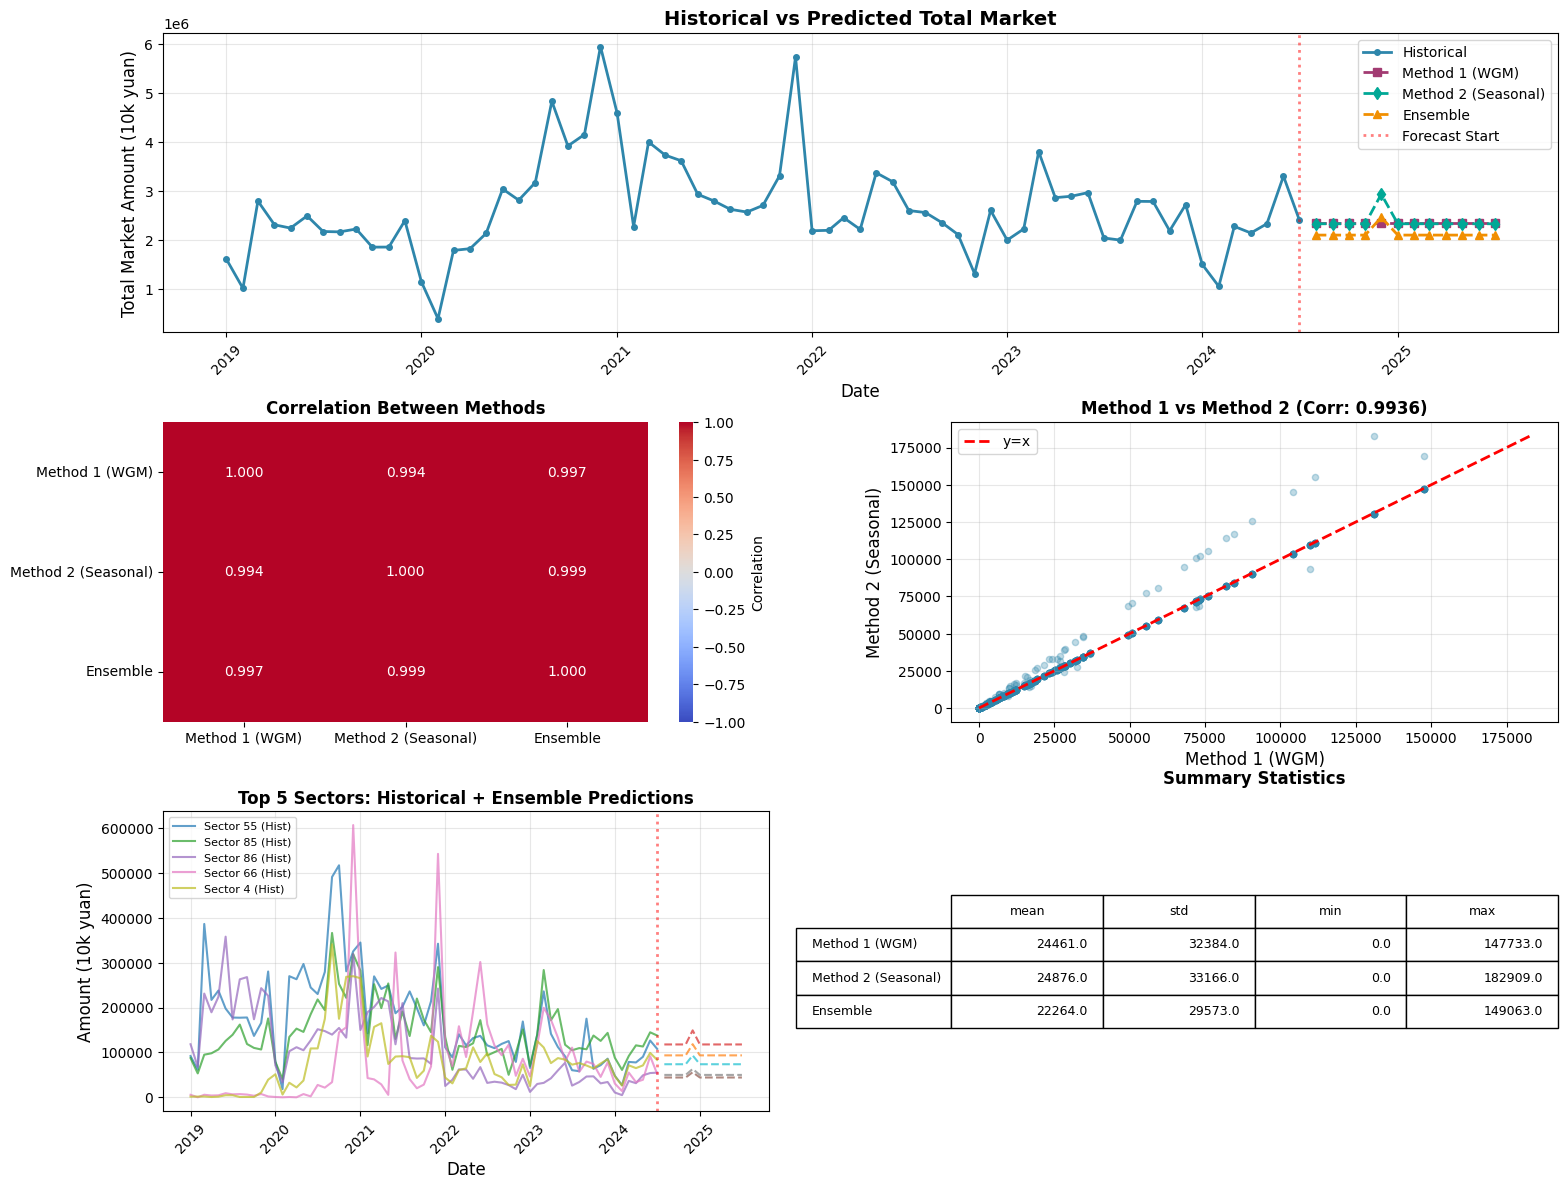


SUMMARY STATISTICS
Historical - Last month: 2,406,309, Last 6 months mean: 2,258,162

Method 1 - Mean: 24,461, Total: 28,178,949
Method 2 - Mean: 24,876, Total: 28,657,439
Ensemble - Mean: 22,264, Total: 25,648,148

Correlation (M1 vs M2): 0.9936
Correlation (Ensemble vs M1): 0.9971
Correlation (Ensemble vs M2): 0.9993


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create comparison dataframe
comparison = pd.DataFrame({
    'Method 1 (WGM)': method1_predictions.values.flatten(),
    'Method 2 (Seasonal)': method2_predictions.values.flatten(),
    'Ensemble': ensemble_predictions.values.flatten()
})

# Create figure with subplots
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Historical + Predictions (Total Market)
ax = fig.add_subplot(gs[0, :])

# Historical total market
historical_total = amount_matrix.sum(axis=1)
historical_dates = pd.date_range(start='2019-01', periods=len(historical_total), freq='MS')

# Future predictions
method1_by_time = method1_predictions.sum(axis=1)
method2_by_time = method2_predictions.sum(axis=1)
ensemble_by_time = ensemble_predictions.sum(axis=1)

# Create future dates
future_dates = pd.date_range(start='2024-08', periods=12, freq='MS')

# Plot
ax.plot(historical_dates, historical_total, 'o-', label='Historical', 
        linewidth=2, markersize=4, color='#2E86AB')
ax.plot(future_dates, method1_by_time.values, 's--', label='Method 1 (WGM)', 
        linewidth=2, markersize=6, color='#A23B72')
ax.plot(future_dates, method2_by_time.values, 'd--', label='Method 2 (Seasonal)', 
        linewidth=2, markersize=6, color='#00A896')
ax.plot(future_dates, ensemble_by_time.values, '^--', label='Ensemble', 
        linewidth=2, markersize=6, color='#F18F01')

# Add vertical line at prediction start
ax.axvline(x=historical_dates[-1], color='red', linestyle=':', 
           linewidth=2, alpha=0.5, label='Forecast Start')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Market Amount (10k yuan)', fontsize=12)
ax.set_title('Historical vs Predicted Total Market', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# 2. Correlation heatmap
ax = fig.add_subplot(gs[1, 0])
corr = comparison.corr()
sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            ax=ax, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation Between Methods', fontsize=12, fontweight='bold')

# 3. Scatter: Method 1 vs Method 2
ax = fig.add_subplot(gs[1, 1])
ax.scatter(comparison['Method 1 (WGM)'], comparison['Method 2 (Seasonal)'], 
          alpha=0.3, s=20, color='#2E86AB')

max_val = max(comparison['Method 1 (WGM)'].max(), comparison['Method 2 (Seasonal)'].max())
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='y=x')

ax.set_xlabel('Method 1 (WGM)', fontsize=12)
ax.set_ylabel('Method 2 (Seasonal)', fontsize=12)
ax.set_title(f'Method 1 vs Method 2 (Corr: {corr.loc["Method 1 (WGM)", "Method 2 (Seasonal)"]:.4f})', 
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Top 5 sectors: Historical + Predictions
ax = fig.add_subplot(gs[2, 0])

# Get top 5 sectors by historical mean
top_sectors = amount_matrix.mean().nlargest(5).index.tolist()

for sector in top_sectors:
    # Historical
    hist_values = amount_matrix[sector].values
    ax.plot(historical_dates, hist_values, '-', label=f'Sector {sector} (Hist)', 
            linewidth=1.5, alpha=0.7)
    
    # Ensemble predictions
    ensemble_sector = ensemble_predictions[sector].values
    ax.plot(future_dates, ensemble_sector, '--', linewidth=1.5, alpha=0.7)

ax.axvline(x=historical_dates[-1], color='red', linestyle=':', 
           linewidth=2, alpha=0.5)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Amount (10k yuan)', fontsize=12)
ax.set_title('Top 5 Sectors: Historical + Ensemble Predictions', fontsize=12, fontweight='bold')
ax.legend(fontsize=8, loc='upper left')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# 5. Summary statistics table
ax = fig.add_subplot(gs[2, 1])
stats = comparison.describe().T[['mean', 'std', 'min', 'max']]
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=stats.values.round(0), 
                rowLabels=stats.index,
                colLabels=stats.columns,
                cellLoc='right',
                loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
ax.set_title('Summary Statistics', fontsize=12, fontweight='bold', pad=20)

# Save and show
output_path = Path(CONFIG_OUTPUT['output_dir']) / 'ensemble_comparison.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"Historical - Last month: {historical_total.iloc[-1]:,.0f}, "
      f"Last 6 months mean: {historical_total.tail(6).mean():,.0f}")
print(f"\nMethod 1 - Mean: {comparison['Method 1 (WGM)'].mean():,.0f}, "
      f"Total: {method1_by_time.sum():,.0f}")
print(f"Method 2 - Mean: {comparison['Method 2 (Seasonal)'].mean():,.0f}, "
      f"Total: {method2_by_time.sum():,.0f}")
print(f"Ensemble - Mean: {comparison['Ensemble'].mean():,.0f}, "
      f"Total: {ensemble_by_time.sum():,.0f}")
print(f"\nCorrelation (M1 vs M2): {corr.loc['Method 1 (WGM)', 'Method 2 (Seasonal)']:.4f}")
print(f"Correlation (Ensemble vs M1): {corr.loc['Ensemble', 'Method 1 (WGM)']:.4f}")
print(f"Correlation (Ensemble vs M2): {corr.loc['Ensemble', 'Method 2 (Seasonal)']:.4f}")